In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
import sklearn as skl
import xgboost
import math
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler

In [2]:
# XGBOOST, feature importances

In [3]:
# GEOGRAFICZNIE UZUPELNIAMY NA PODSTAWIE BLOKÓW
# geograficzne to:staddr, postcode, latitude, longitude, community board
# council district, census tract, NTA
# STORIES - BIERZEMY SREDNIA Z BLOKOW
# ext na dwie kolumny e i g
# EASEMENT - DWIE KOLUMNY E I N
# obliczyc powierzchnie i normalizować

In [4]:
def calc_average_from_block(dataset, block, column):
    new_df = dataset[dataset["BLOCK"] == block]
    return new_df[column].mean()

def calc_postal_code(data, block, column): # postcode, community board, council district, census tract
    new_df = data[data["BLOCK"] == block]
    return max(new_df[column].unique())

def calc_district(data, block, column):
    new_df = data[data["BLOCK"] == block]
    return new_df[column].unique()[0]

In [5]:
def prepare_data(path):
    data = pd.read_csv(path)
    data.drop(labels=["BBLE", "LOT","PERIOD", "VALTYPE",
                  "Borough", "New Georeferenced Column",
                  "OWNER", "AVLAND2", "AVTOT2",
                  "EXLAND2", "EXTOT2","BIN", "EXCD1", "EXCD2",
                  "EXMPTCL", "YEAR", "STADDR"],axis=1, inplace=True)
    data["EASEMENT"] = data["EASEMENT"].fillna("0")
    data["EXT"] = data["EXT"].fillna("0")
    data.loc[(data["EASEMENT"] == "F"), "EASEMENT"] = "E"
    data.loc[(data["EASEMENT"] == "G"), "EASEMENT"] = "E"
    data.loc[(data["EASEMENT"] == "H"), "EASEMENT"] = "E"
    data.loc[(data["EASEMENT"] == "I"), "EASEMENT"] = "E"
    data["EXT_E"] = 0
    data["EXT_G"] = 0
    data["EASEMENT_E"] = 0
    data["EASEMENT_N"] = 0
    data.loc[(data["EXT"] == "E"), "EXT_E"] = 1
    data.loc[(data["EXT"] == "EG"), "EXT_E"] = 1
    data.loc[(data["EXT"] == "G"), "EXT_G"] = 1
    data.loc[(data["EXT"] == "EG"), "EXT_G"] = 1
    data.loc[(data["EASEMENT"] == "E"), "EASEMENT_E"] = 1
    data.loc[(data["EASEMENT"] == "N"), "EASEMENT_N"] = 1
    data.drop(["EXT", "EASEMENT"], axis=1, inplace=True)
    data["STORIES"].fillna(method="ffill", inplace=True)
    data["POSTCODE"].loc[data["POSTCODE"].isnull()] = calc_postal_code(data, data["BLOCK"], "POSTCODE")
    data["Community Board"].loc[data["Community Board"].isnull()] = calc_postal_code(data, data["BLOCK"], "Community Board")
    data["Council District"].loc[data["Council District"].isnull()] = calc_postal_code(data, data["BLOCK"], "Council District")
    data["Census Tract"].loc[data["Census Tract"].isnull()] = calc_postal_code(data, data["BLOCK"], "Census Tract")
    data["NTA"].loc[data["NTA"].isnull()] = calc_district(data, data["BLOCK"], "NTA")
    data["Latitude"].loc[data["Latitude"].isnull()] = calc_average_from_block(data, data["BLOCK"], "Latitude")
    data["Longitude"].loc[data["Longitude"].isnull()] = calc_average_from_block(data, data["BLOCK"], "Longitude")
    data["STORIES"].loc[data["STORIES"].isnull()] = calc_average_from_block(data, data["BLOCK"], "STORIES")
    data = data.loc[data["FULLVAL"] != 0]
    
    le = preprocessing.OneHotEncoder()
    encoded_fit = le.fit_transform(data.BLDGCL.values.reshape(-1,1))
    encoded_fit.toarray()
    dummies = pd.get_dummies(data[["BLDGCL"]])
    data = pd.concat([data, dummies], axis = 1)
    
    encoded_fit = le.fit_transform(data.NTA.values.reshape(-1,1))
    encoded_fit.toarray()
    dummies = pd.get_dummies(data[["NTA"]])
    data = pd.concat([data, dummies], axis = 1)
    
    encoded_fit = le.fit_transform(data.TAXCLASS.values.reshape(-1,1))
    encoded_fit.toarray()
    dummies = pd.get_dummies(data[["TAXCLASS"]])
    data = pd.concat([data, dummies], axis = 1)
    
    encoded_fit = le.fit_transform(data.POSTCODE.values.reshape(-1,1))
    encoded_fit.toarray()
    dummies = pd.get_dummies(data[["POSTCODE"]])
    data = pd.concat([data, dummies], axis = 1)
    
    data.drop(labels=["BLDGCL", "NTA","TAXCLASS","POSTCODE"] ,axis=1, inplace=True)
    
#     le = preprocessing.LabelEncoder()
#     le.fit(data['BLDGCL'])
#     data.BLDGCL = le.transform(data.BLDGCL)
#     le.fit(data['NTA'])
#     data.NTA = le.transform(data.NTA)
#     le.fit(data['TAXCLASS'])
#     data.TAXCLASS = le.transform(data.TAXCLASS)
#     le.fit(data['POSTCODE'])
#     data.POSTCODE = le.transform(data.POSTCODE)
    
    sc = MinMaxScaler()
    data['Latitude'] = sc.fit_transform(data['Latitude'].values.reshape(-1,1))
    data['Longitude'] = sc.fit_transform(data['Longitude'].values.reshape(-1,1))
    data['LTFRONT'] = sc.fit_transform(data['LTFRONT'].values.reshape(-1,1))
    data['LTDEPTH'] = sc.fit_transform(data['LTDEPTH'].values.reshape(-1,1))
    data['BLDDEPTH'] = sc.fit_transform(data['BLDDEPTH'].values.reshape(-1,1))
    data['BLDFRONT'] = sc.fit_transform(data['BLDFRONT'].values.reshape(-1,1))
#     data['AVLAND'] = sc.fit_transform(data['AVLAND'].values.reshape(-1,1))
#     data['AVTOT'] = sc.fit_transform(data['AVTOT'].values.reshape(-1,1))
#     data['EXLAND'] = sc.fit_transform(data['EXLAND'].values.reshape(-1,1))
#     data['EXTOT'] = sc.fit_transform(data['EXTOT'].values.reshape(-1,1))
#     data["AVLAND"] = np.log10(data["AVLAND"].loc[data["AVLAND"] != 0])
#     data["AVTOT"] = np.log10(data["AVTOT"].loc[data["AVTOT"] != 0])
#     data["EXLAND"] = np.log10(data["EXLAND"].loc[data["EXLAND"] != 0])
#     data["EXTOT"] = np.log10(data["EXTOT"].loc[data["EXTOT"] != 0])
    data.drop(labels=["BLOCK"],axis=1, inplace=True)
    return data

In [6]:
def divide_data(data):
    X = data.loc[:, data.columns != 'FULLVAL']
    y = data["FULLVAL"]
    return X, y

In [7]:
def train_test(data):
    train, test = skl.model_selection.train_test_split(data, test_size=25)
    X_train, y_train = divide_data(train)
    X_test, y_test = divide_data(test)
    return X_train, y_train, X_test, y_test

In [8]:
def train_model(X_train, y_train):
    model = xgboost.XGBRegressor(n_estimators=1000, max_depth=7,
                         eta=0.1, subsample=0.7, colsample_bytree=0.8)
    model.fit(X_train, y_train)
    return model

In [9]:
def save_model(X_train, y_train):
    model = xgboost.XGBRegressor(n_estimators=1000, max_depth=7,
                         eta=0.1, subsample=0.7, colsample_bytree=0.8)
    model.fit(X_train, y_train)
    model.save_model('model.json')

In [10]:
data = prepare_data("data/train_data.csv")
X, y = divide_data(data)
save_model(X, y)

/home/szaryvip/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


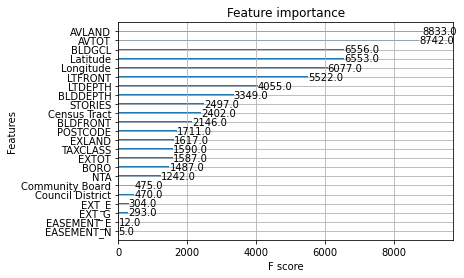

<Figure size 432x288 with 0 Axes>

In [16]:
model = xgboost.XGBRegressor()
model.load_model('model.json')
# col = data.loc[:,data.columns != 'FULLVAL'].columns.values.tolist()
# # plt.bar(col, model.feature_importances_)
xgboost.plot_importance(model)
plt.show()

# data.describe()

In [12]:
y = []
for _ in range(10):
    X_train, y_train, X_test, y_test = train_test(data)
    model = train_model(X_train, y_train)
    predictions = model.predict(X_test)
    y.append(metrics.mean_absolute_error(predictions, y_test))
sum(y)/len(y)

KeyboardInterrupt: 

In [ ]:
np.std(y)
